# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average (cloud-free) pixel values.

#### Initialize

In [308]:
import ee
ee.Initialize()

In [309]:
#standard modules
import os
import sys
import numpy as np
import pandas as pd
import colorsys
from matplotlib import pylab as plt
import matplotlib.dates as mdates

from IPython.display import display, Image
%matplotlib inline

# custom modules
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))
from kml_reader import read_kml
import interpolated_lookup_tables as iLUT
from ee_requests import request_meanRadiance
from atmcorr_timeseries import surface_reflectance_timeseries
from mission_specifics import ee_bandnames
from mission_specifics import common_bandnames
from plots import plot_timeseries

### User Input

In [310]:
# read kml file
# target = 'Lake Nyos'
# geom = read_kml('RED_LAKES.kml', target)# <-- Earth Engine geometry
target = 'Kelimutu_TAP'
geom = ee.Geometry.Point(121.81734, -8.768961).buffer(150)

# start and end of time series
startDate = '1990-01-01'# YYYY-MM-DD
stopDate  = '2017-01-01'# YYYY-MM-DD

# satellite missions
missions = ['Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4']

# cloud and cloud shadow mask?
removeClouds = True

### Time series extractor

This is the function for extracting atmospherically corrected, cloud-free time series for a given satellite mission.


In [311]:
def timeseries_extrator(mission):
    
    # interpolated lookup tables 
    iLUTs = iLUT.handler(mission) 
    iLUTs.get()
    
    # earth engine request
    print('Getting data from Earth Engine.. ')
    request = request_meanRadiance(geom, ee.Date(startDate), ee.Date(stopDate), \
                                   mission, removeClouds)
    meanRadiance = request.getInfo()
    print('Data collection complete')
    
    # return if no pixels available
    num = len(meanRadiance['features'])
    if num == 0:
        return {}
    else:
        print('number of valid images = {}'.format(num))
    
    # atmospheric correction
    print('Running atmospheric correction')
    timeseries = surface_reflectance_timeseries(meanRadiance, iLUTs, mission)
    print('Done')
    
    return timeseries  

### All satellite missions
These lines of code extract time series for each mission and join them together

In [312]:
# will store results here (and use consistent band names)
allTimeSeries = {
    'blue':[], 
    'green':[], 
    'red':[], 
    'nir':[],
    'swir1':[], 
    'swir2':[],
    'timeStamp':[]
}

for mission in missions:
    
    timeseries = timeseries_extrator(mission) 
    
    # names of wavebands
    eeNames = ee_bandnames(mission)
    commonNames = common_bandnames(mission)
    
    # add mission to timeseries
    for key in timeseries.keys():
        if key[0] == 'B':
            commonName = commonNames[eeNames.index(key)]
            if commonName in allTimeSeries.keys():
                allTimeSeries[commonName].append(timeseries[key])
        if key == 'timeStamp':
            allTimeSeries['timeStamp'].append(timeseries['timeStamp'])

Loading interpolated look up tables (.ilut) for Sentinel2..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 22
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat8..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 77
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat7..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 348
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat5..
Success
Getting data from Earth Engine.. 
Data collection complete
number of valid images = 315
Running atmospheric correction
Done
Loading interpolated look up tables (.ilut) for Landsat4..
Success
Getting data from Earth Engine.. 
Data collection complete


In [313]:
# flatten each mission into a single list
def flatten(multilist):
    if isinstance(multilist[0], list):
        return [item for sublist in multilist for item in sublist]
    else:
        return multilist

for key in allTimeSeries.keys():
    allTimeSeries[key] = flatten(allTimeSeries[key])

### Data post-processing
Resample the data into daily intervals, interpolate between data points and clip for the time period we are interested in.

In [318]:
def postProcessing(allTimeSeries):
    
    # create a dataframe
    df = pd.DataFrame.from_dict(allTimeSeries)

    # timestamp as index
    df.index = [pd.datetime.utcfromtimestamp(t) for t in allTimeSeries['timeStamp']]
    df = df.drop('timeStamp', axis=1)

    # resample to daily
    daily = df.resample('D').mean()

    # fill in NaNs
    interpolated = daily.interpolate().ffill().bfill()

    # clip time series
    return interpolated.truncate(before=startDate, after=stopDate)

In [319]:
# DataFrame of post-processed timeseries
DF = postProcessing(allTimeSeries)

### Hue Saturation Value

A new color space. Here we take (red, green, blue) surface reflectances and calulate (hue, saturation, value).

In [320]:
rgb = list(zip(DF['red'], DF['green'], DF['blue']))
DF['hue'] = [colorsys.rgb_to_hsv(x[0], x[1], x[2])[0] for x in rgb]
DF['sat'] = [colorsys.rgb_to_hsv(x[0], x[1], x[2])[1] for x in rgb]
DF['val'] = [colorsys.rgb_to_hsv(x[0], x[1], x[2])[2] for x in rgb]

### Hue Stretch
A hue visualization created by 'strecthing' saturation  and value so that they equal 1, then converting this new hsv triplet back into rgb to display on the screen

In [321]:
hue_stretch = [colorsys.hsv_to_rgb(hue,1,1) for hue in DF['hue']]

### Plot

This function defines a plot to put the data in

In [322]:
def figure_plotting_space():

    fig = plt.figure(figsize=(6,12))
    bar_height = 0.04
    mini_gap = 0.03
    gap = 0.05
    graph_height = 0.24

    axH = fig.add_axes([0.1,gap+3*graph_height+2.5*mini_gap,0.87,bar_height])
    axS = fig.add_axes([0.1,gap+2*graph_height+2*mini_gap,0.87,graph_height])
    axV = fig.add_axes([0.1,gap+graph_height+mini_gap,0.87,graph_height])
    
    return fig, axH, axS, axV

This function plots the 'hut stretch' color bar

In [323]:
def plot_colorbar(ax,image,ylabel=False):
        
    # plot image inside of figure 'axes'
    ax.imshow(image, interpolation='nearest', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(ylabel)

This function plots the time series graphs

In [324]:
def plot_timeseries(ax, name):

    # original time series
    ax.plot(DF[name],color='#1f77b4')
    ax.set_ylabel(name)
    ax.set_xlim(pd.datetime.strptime(startDate,'%Y-%m-%d'),\
                pd.datetime.strptime(stopDate,'%Y-%m-%d'))

    # boxcar
#     D, Y = interpolate_series(t,y,start,stop)
#     boxD, boxY = boxcar_average(D,Y,180)
#     ax.plot(boxD,boxY,'r-')

    # make the dates exact
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

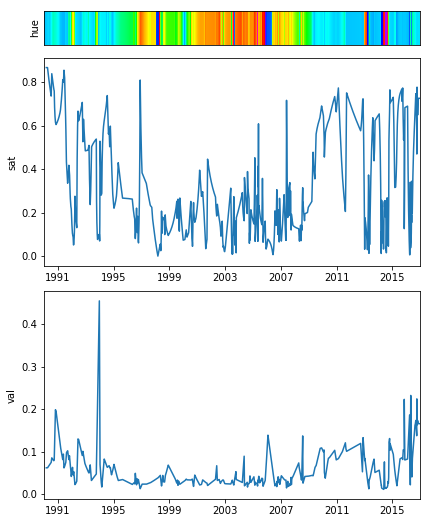

In [326]:
fig, axH, axS, axV = figure_plotting_space()
plot_colorbar(axH,[hue_stretch], ylabel='hue')
plot_timeseries(axS,'sat')
plot_timeseries(axV,'val')

#### Save to excel

In [ ]:
# # create an excel directory
# excel_dir = os.path.join(base_dir,'files','excel')
# if not os.path.exists(excel_dir):
#     os.makedirs(excel_dir)

# # create pandas data frame
# df = pd.DataFrame.from_dict(timeSeries)

# # save to excel
# df.to_excel(os.path.join(excel_dir, target+'_'+mission+'.xlsx'), index=False)